# Barrents sea - Data Scientist Notebook for CTD data processing

## Introduction
This Notebook provides guidance and support for data processing of Conductivity Temperature Depth (CTD) measurements from instruments onboard of research vessels, and acquired from 1991 to 2020.  

The data access relies on queries to remote OPeNDAP servers hosting the CTD data, and the data processing makes use of the Geostatistical Library (RIntaros / RGeostats) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements.

The CTD data access point is pre-configured for the OPeNDAP Hyrax server operated by the Institute of Marine Research, Norwegian Marine Data Centre, Norway
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html

Note: for this server, the **.nc4** extension from the data access URLs is not supported.

The multi-year selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project (https://cordis.europa.eu/project/id/727890).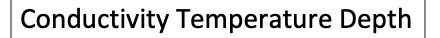.

More information on the RGeostats package is available on: http://rgeostats.free.fr/.

# Extraction of NetCDF Data

## Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os

from helpers import *

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

from datetime import datetime, timedelta

from lxml import html
import requests

### Set-up

#### Server URL
We invite the data scientist to visit the URL below, to get an understanding of the server content, in particular the years of the campaings at sea, and the naming convention for the "platforms" (i.e. the research vessels).

In [2]:
# Define URL of Norwegian Marine Data Centre (NODC) data
nodc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' # on NODC server

server_url = nodc_url

#### Define Time of Interest
As a start we simply define one **year** of interest. Time range filters will operate within this given year. 
Multi-year analysis would require some adaptation to the code. 

In [3]:
year = 2003 # Define year of interest

### Retrieval of DDS info
The OPeNDAP's Dataset Descriptor Structure (DDS) delivers lightweight information, useful for the application developer to visually analyse and understand the dataset at hand (geographic and temporal extends covered, and eventual data gaps).  

Access data using the DDS info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH'.

In [4]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

# get all content of the server_url, and then filter it with year and available platforms
page = requests.get(server_url)
webpage = html.fromstring(page.content)

urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(str(year)+'.nc.dds')]

for u in urls_filtered:
    
    dds = f'{server_url}/{u}'; print(dds)
    
    # Find platform code
    pc = dds.split('_')[0][-2:]
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'

# Extract all platform_codes
platform_codes = [kd for kd in depth_stop_dict.keys()]
print(f'Available platforms in given year {year}: {platform_codes}')

# Print dimensions
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

http://opendap1.nodc.no/opendap/physics/point/yearly//58AA_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GS_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GT_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58HJ_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58JH_CTD_2003.nc.dds
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


### Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

#### Create Position_Dict

In [5]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2003.nc?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2003.nc?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
We create a dictionary for the positions (the nominal space and time position of an observation) in order to support the optimisation of remote queries to the OPeNDAP server. 
The creation of this dictionary, based on the OPeNDAP DDS lightweight information, is computationally very efficient.

Generate a pandas dataframe (*position_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms, in order to plot and visualise them.

In [6]:
# Load locations (long & lat) and TIME of ALL measurements
start_date = datetime(1950, 1, 1)
    
position_df_raw = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df_raw = position_df_raw.append(test) 
    
position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
position_df_raw = position_df_raw.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df_raw)} measurement locations')
position_df_raw

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


##### Remove Duplicates 
Sometimes, due to the conditions at sea, sensors can generate duplicated information. Duplicates are found based on the *Time* field, and removed from the dataframe to avoid duplication of information.

In [7]:
# Check if there are duplicates
duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]

# Drop duplicates 
position_df = position_df_raw.drop_duplicates(subset=['Time'])

print(f'All Positions: \t\t{len(position_df_raw)} \n\
Duplicates: \t\t{len(duplicates)} / {len(position_df_raw)} \n\
Remaining: \t\t{len(position_df)} / {len(position_df_raw)}')

display(position_df)

All Positions: 		3209 
Duplicates: 		0 / 3209 
Remaining: 		3209 / 3209


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Plot Histogram of measurements of the given year

<AxesSubplot:title={'center':'Histogram of available measurements in 2003'}, xlabel='Month', ylabel='Frequency'>

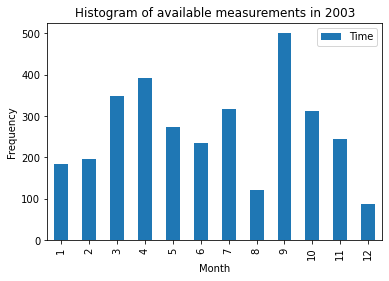

In [8]:
position_df['Time'].groupby(position_df["Time"].dt.month).count().plot(kind="bar", 
                                                               title=(f'Histogram of available measurements in {year}'),
                                                               xlabel='Month',
                                                               ylabel='Frequency', legend=True)

#### Plot Positions
Plot locations on an interactive plot. Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [9]:
def plotIteractive(df2p, title, xlim, ylim, bbox=False):
    output_notebook() # necessary to show the plot 

    hover = HoverTool(
            tooltips=[
                ("Index_ABS", "@Index_ABS"),
                ("(Long, Lat)", "(@Longitude, @Latitude)"),
                ("Platform", "@Platform"),            
            ]
        )

    p = figure(plot_width=500, 
               plot_height=500, 
               tools=[hover],
               title=title,
               x_range=xlim, 
               y_range=ylim)
    
    # Add positions by platform in different colors
    colors = ['blue','red','green','orange','purple','gold','cyan','lime','magenta']
    for i, pc in enumerate(df2p['Platform'].unique()):
        p.circle('Longitude', 'Latitude', 
                 size=4, color=colors[i], fill_color='white', 
                 source=df2p[df2p['Platform']==pc], 
                 legend_label=f'Platform {pc}')

    # Add BBOX area
    if bbox: 
        bbox_val = list(bbox_dict.values())[0]
        p.quad(left=bbox_val[0], right=bbox_val[1], top=bbox_val[3], bottom=bbox_val[2], 
               legend_label=list(bbox_dict.keys())[0], fill_color='grey', fill_alpha=0.0, line_color="black")

    p.legend.location = "right"
    show(p)

In [10]:
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)

title = f'All measurement points'
plotIteractive(position_df, title, xlim, ylim, bbox=False)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX

In [11]:
# Now apply the arctic bounding box in the format: minLong - maxLong; minLat - maxLat (eg 30W - 60E; 50N - 80 N) 
bbox_dict = {}

# bbox_dict['BBOX=UserAOI'] = [-4, 18, 42, 72]
# bbox_dict['BBOX=North Sea'] = [-5, 15, 53, 60]
bbox_dict['User_AOI_withMargins'] = [-4, 18, 42, 72]

bbox_key = list(bbox_dict.keys())[0]
bbox = bbox_dict[bbox_key]

In [12]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox[3])]
print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

title = f'Filtered data: {bbox_key}'
plotIteractive(position_df_bbox, title, xlim, ylim, bbox_dict)

Year: 2003
BBOX: User_AOI_withMargins
Selected positions (out of available positions): 1745 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [13]:
# Define start and end date in the format [day,month,year]
time_start = [1,9,year] 
time_end = [30,11,year] 

time_start = datetime(time_start[2], time_start[1], time_start[0])
time_end = datetime(time_end[2], time_end[1], time_end[0])

time_filter_str = f'{time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}'
print(f'Time Filter: {time_filter_str}')

position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]
display(position_df_bbox_timerange)

title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotIteractive(position_df_bbox_timerange, title, xlim, ylim, bbox_dict)

Time Filter: 2003-09-01 - 2003-11-30


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
535,8.1725,63.068802,2003-10-16 23:33:12,AA,535
536,8.1345,63.105801,2003-10-17 06:11:56,AA,536
537,8.1028,63.127300,2003-10-17 06:55:18,AA,537
538,8.1013,63.127998,2003-10-17 13:35:48,AA,538
539,8.3798,62.953201,2003-10-17 22:52:00,AA,539
...,...,...,...,...,...
920,6.1065,62.445301,2003-11-06 02:16:06,JH,3179
921,5.9402,62.088299,2003-11-06 08:54:05,JH,3180
922,5.4093,63.031502,2003-11-06 23:08:57,JH,3181


Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [14]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None)
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Plot Filtered Positions
Plot filtered positions with the relavite extent of those positions only.

In [15]:
xlim_small = (min(position_df_bbox_timerange['Longitude'])-1, max(position_df_bbox_timerange['Longitude'])+1)
ylim_small = (min(position_df_bbox_timerange['Latitude'])-1, max(position_df_bbox_timerange['Latitude'])+1)
title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotIteractive(position_df_bbox_timerange, title, xlim_small, ylim_small)

Loading BokehJS ...

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [16]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} / {len(position_df)}.'

print(f'- Filters: "BBOX={bbox_key}" and "Time={time_filter_str}"\n- Filtered / All (out of available positions): {sel_outof_all}')

display(df_toPlot)

# Dictionary of indices
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# index_dict

- Filters: "BBOX=User_AOI_withMargins" and "Time=2003-09-01 - 2003-11-30"
- Filtered / All (out of available positions): 456 / 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
535,8.1725,63.068802,2003-10-16 23:33:12,AA,535
536,8.1345,63.105801,2003-10-17 06:11:56,AA,536
537,8.1028,63.127300,2003-10-17 06:55:18,AA,537
538,8.1013,63.127998,2003-10-17 13:35:48,AA,538
539,8.3798,62.953201,2003-10-17 22:52:00,AA,539
...,...,...,...,...,...
920,6.1065,62.445301,2003-11-06 02:16:06,JH,3179
921,5.9402,62.088299,2003-11-06 08:54:05,JH,3180
922,5.4093,63.031502,2003-11-06 23:08:57,JH,3181


## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only the selected variable** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Data Extraction
The CTD data is extracted based on the previously selected positions, for which we have  

### Define Parameters

In [17]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP'] #, 'CNDC', 'PSAL']; 
assert all([elem in vars_main for elem in vars_sel])

In [18]:
# Define DEPTH
depth1 = 0
depth2 = 50
depth = depth2

### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [19]:
df_toPlot['Platform'].unique()

array(['AA', 'GS', 'GT', 'HJ', 'JH'], dtype=object)

In [20]:
data_dict = {}
metadata = {}

for pc in df_toPlot['Platform'].unique():
    
    metadata[pc] = {}

    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0
    metadata[pc]['depth_m_v2'] = depth2 #pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================

    # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

    #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

    metadata[pc]['depth_newindex4xr_v1'] = 0

    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)

    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

    remote_data, data_attr = fetch_data(url_q, year)

    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}

    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 50
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:50]
['58AA' 'H\\303\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 50
Platform GS URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404],

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe overview_df is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [21]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\303\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [22]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; Initial DEPTH range: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[k]["data"].variables)}')


Printing DEPTH range for analyis:
AA; Initial DEPTH range: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GS; Initial DEPTH range: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GT; Initial DEPTH range: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
HJ; Initial DEPTH range: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
JH; Initial DEPTH range: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']


In [23]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False},
 'GT': {'TEMP': False},
 'HJ': {'TEMP': False},
 'JH': {'TEMP': False}}

### Apply Previous Filter (BBOX and Time Range), and add Filter by DEPTH
This section allows filtering the xarray data using the selected DEPTH, as well as the data previously filtered based on BBOX and time range (Filtered Position section)

The output of this operation is a *filtered_xarr* xarray dataset, containing one variable at the specified DEPTH. 

#### Data filtered by DEPTH

In [24]:
filtered_xarr_dict = {}

print(f'Selected range of DEPTH: {depth1} - {depth2}m\n')
for pc in data_dict.keys():

    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
    display(filtered_xarr_dict[pc])

Selected range of DEPTH: 0 - 50m

Platform: AA; Vertical min: 0.0; Var: TEMP


<xarray.Dataset>
Dimensions:    (DEPTH: 51, LATITUDE: 108, LONGITUDE: 108, TIME: 108)
Coordinates:
  * TIME       (TIME) float64 1.965e+04 1.965e+04 ... 1.969e+04 1.969e+04
  * LATITUDE   (LATITUDE) float32 63.07 63.11 63.13 63.13 ... 60.82 60.87 60.88
  * LONGITUDE  (LONGITUDE) float32 8.172 8.134 8.103 8.101 ... 5.341 5.365 5.466
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 11.37 11.2 11.94 ... 10.41 10.35 10.38
Attributes: (12/152)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          2810

Platform: GS; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 51, LATITUDE: 176, LONGITUDE: 176, TIME: 176)
Coordinates:
  * TIME       (TIME) float64 1.962e+04 1.964e+04 ... 1.969e+04 1.969e+04
  * LATITUDE   (LATITUDE) float32 63.42 61.21 61.12 61.04 ... 67.26 68.37 68.37
  * LONGITUDE  (LONGITUDE) float32 6.768 -3.686 -3.276 ... 12.31 16.13 16.15
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 12.1 12.11 12.12 ... 7.826 7.844 7.849
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: GT; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 51, LATITUDE: 61, LONGITUDE: 61, TIME: 61)
Coordinates:
  * TIME       (TIME) float64 1.962e+04 1.962e+04 ... 1.963e+04 1.964e+04
  * LATITUDE   (LATITUDE) float32 60.67 61.2 61.65 60.21 ... 56.74 57.13 57.69
  * LONGITUDE  (LONGITUDE) float32 -0.3033 -0.2672 -0.347 ... -0.5513 -0.5153
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 13.39 13.39 13.39 ... 12.9 12.9 12.9
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: HJ; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 51, LATITUDE: 71, LONGITUDE: 71, TIME: 71)
Coordinates:
  * TIME       (TIME) float64 1.966e+04 1.966e+04 ... 1.968e+04 1.968e+04
  * LATITUDE   (LATITUDE) float32 70.44 70.36 70.39 70.29 ... 68.06 68.18 68.23
  * LONGITUDE  (LONGITUDE) float32 17.78 17.27 17.51 17.78 ... 10.49 11.05 12.42
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 7.682 7.647 7.636 ... 8.645 8.644 8.643
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: JH; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 51, LATITUDE: 40, LONGITUDE: 40, TIME: 40)
Coordinates:
  * TIME       (TIME) float64 1.964e+04 1.964e+04 ... 1.967e+04 1.967e+04
  * LATITUDE   (LATITUDE) float32 69.01 69.0 69.0 69.0 ... 62.09 63.03 62.9 62.6
  * LONGITUDE  (LONGITUDE) float32 12.0 12.34 12.65 13.0 ... 5.409 5.504 5.42
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 9.514 9.516 9.516 ... 11.04 11.03 11.01
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [25]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=108, DEPTH=51
PC GS	Filtered Dims: TIME=176, DEPTH=51
PC GT	Filtered Dims: TIME=61, DEPTH=51
PC HJ	Filtered Dims: TIME=71, DEPTH=51
PC JH	Filtered Dims: TIME=40, DEPTH=51


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

<xarray.Dataset>
Dimensions:  (DEPTH: 51, TIME: 456)
Coordinates:
  * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 nan 13.39 13.39 13.39 ... 7.826 7.844 7.849
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

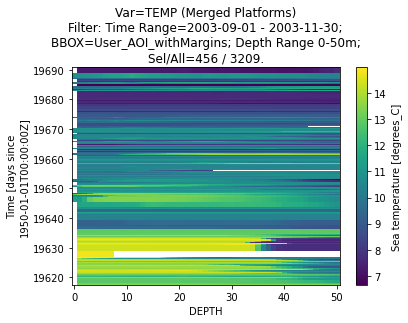

In [26]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
    
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
    display(merged_arr[var])

#### Querying and Plotting one Platform only 

In [27]:
# # This is only if you want to filter & plot one platform only
# for v in vars_sel: 
#     print(f"Var to plot: {v}")

#     title = f'Platform={pc}, Var={v}\nFilter: {bbox_key}; DepthRange: {depth1}-{depth2}m; \nTimeRange={time_filter_str}\nSel/All={sel_outof_all}'

#     plotFilteredVar(filtered_xarr[v], title=title)

To Recap:
* ```data_dict[pc]['data']```: contains the xarray extracted from the url (eg from **0** to **depth2**, for ALL locations)
* ```filtered_xarr```: contains the xarray filtered from ```data_dict[pc]['data']``` (ie from **depth1** to **depth2**, for filtered locations (BBOX and time_range))

### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file expected by the RGeostats module.


In [28]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 

        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vaissel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vaissel_name
rank,,,,,,
0,8.1725,63.068802,19646.981389,11.366,0,AA
1,8.1345,63.105801,19647.258287,10.468,0,AA
2,8.1028,63.127300,19647.288403,10.896,0,AA
3,8.1013,63.127998,19647.566528,10.304,0,AA
4,8.3798,62.953201,19647.952778,12.890,0,AA
...,...,...,...,...,...,...
23251,6.1065,62.445301,19667.094514,10.766,50,JH
23252,5.9402,62.088299,19667.370891,10.856,50,JH
23253,5.4093,63.031502,19667.964549,9.995,50,JH


### Assign *Profil_id* to the unique positions

In [29]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vaissel_name,Profil_id
rank,,,,,,,
0,8.1725,63.068802,19646.981389,11.366,0,AA,319
1,8.1345,63.105801,19647.258287,10.468,0,AA,317
2,8.1028,63.127300,19647.288403,10.896,0,AA,316
3,8.1013,63.127998,19647.566528,10.304,0,AA,315
4,8.3798,62.953201,19647.952778,12.890,0,AA,322
...,...,...,...,...,...,...,...
23251,6.1065,62.445301,19667.094514,10.766,50,JH,279
23252,5.9402,62.088299,19667.370891,10.856,50,JH,273
23253,5.4093,63.031502,19667.964549,9.995,50,JH,251


#### Plot Histogram of measurements of the given year

<AxesSubplot:xlabel='Month & Day', ylabel='Count'>

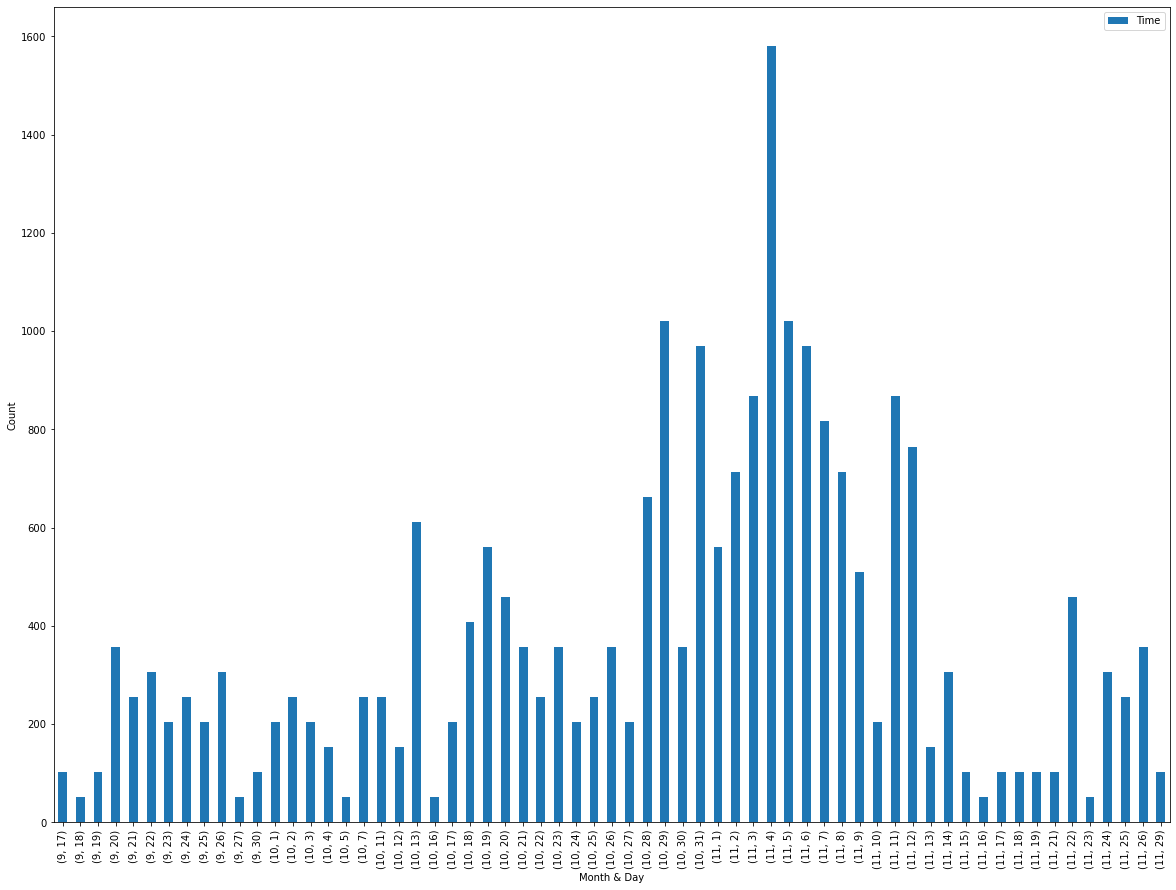

In [30]:
# Create a copy (I need to keep the original as it is, because Time needs to be a floating number)
filtered2csv_multiDepths_time = filtered2csv_multiDepths.copy()

# Convert Time from float to datetime
filtered2csv_multiDepths_time['Time'] = [start_date + timedelta(t) for t in filtered2csv_multiDepths_time.loc[:,'Time']]

# Plot Histogram
filtered2csv_multiDepths_time["Time"].groupby([filtered2csv_multiDepths_time["Time"].dt.month,
                                               filtered2csv_multiDepths_time["Time"].dt.day]).count().plot(figsize=(20,15),
                                                                                                           kind="bar", 
                                                                                                           legend=True, 
                                                                                                           xlabel='Month & Day', 
                                                                                                           ylabel='Count')

### Export to CSV

In [31]:
# Save dataframe to csv
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)
    
csvname = os.path.join(data_output, f'DS_filtered_{"_".join(vars_sel)}_{depth1}-{depth2}m.csv')

filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)

# RGeostats Case Study

## Set-up

### Install R Kernel & Testing

In [32]:
!pip install rpy2

%load_ext rpy2.ipython

### Import variables from Python

In [33]:
import rpy2.robjects as robjects

# BBOX (note it's stored as an array of format: [minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80]]
robjects.globalenv['bbox_key'] = bbox_key
robjects.globalenv['long_min'] = bbox[0]
robjects.globalenv['long_max'] = bbox[1]
robjects.globalenv['lat_min'] = bbox[2]
robjects.globalenv['lat_max'] = bbox[3]

# Time Range
robjects.globalenv['time_filter_str'] = time_filter_str

# Depth Range
robjects.globalenv['depth'] = depth
robjects.globalenv['depth1'] = depth1
robjects.globalenv['depth2'] = depth2

# Directory and CSV Name
robjects.globalenv['data_output'] = data_output 
robjects.globalenv['csvname'] = csvname

# Variables
robjects.globalenv['vars'] = '_'.join(vars_sel) 

In [34]:
%%R
# Check Variables
print('Printing variables imported from Python script')
cat('bbox_key:', bbox_key, '\n')
long_lim   = c(long_min, long_max)
lat_lim    = c(lat_min, lat_max)
cat('long_lim:', long_lim, '\n')
cat('lat_lim:', lat_lim, '\n')
cat('time_filter_str:', time_filter_str, '\n')
cat('depth:', depth, '\n')
cat('depth1:', depth1, '\n')
cat('depth2:', depth2, '\n')
cat('data_output:', data_output, '\n')
cat('csvname:', csvname, '\n')
cat('vars:', vars, '\n')

[1] "Printing variables imported from Python script"
bbox_key: User_AOI_withMargins 
long_lim: -4 18 
lat_lim: 42 72 
time_filter_str: 2003-09-01 - 2003-11-30 
depth: 50 
depth1: 0 
depth2: 50 
data_output: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output 
csvname: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/DS_filtered_TEMP_0-50m.csv 
vars: TEMP 


### Definition of the environment

The next cells have specific contents for loading the library **RIntaros** that the user must choose to run or to skip. Their order is important.

In [35]:
%%R 
suppressWarnings(suppressPackageStartupMessages(library(RIntaros)))

# Defining if the data set must be read or not from the CSV (flag.read)
flag.read = FALSE

## Loading Data

In [36]:
%%R 
# Setup OUR environment and datasets 
dir.name   = getwd()
data.name  = basename(data_output)
file.name  = basename(csvname)

intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)

var = "Temperature"

Then we read the **CSV** file (taking the header line into account) and create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [37]:
%%R 
if (flag.read || ! exists("db0")) db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
db0


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 7
Maximum Number of attributes = 7
Total number of samples      = 23256

Variables
---------
Field =   1 - Name    =  rank - Locator =  NA
Field =   2 - Name    =  Longitude - Locator =  x1
Field =   3 - Name    =  Latitude - Locator =  x2
Field =   4 - Name    =  Time - Locator =  NA
Field =   5 - Name    =  Temperature - Locator =  NA
Field =   6 - Name    =  Depth - Locator =  NA
Field =   7 - Name    =  Profil_id - Locator =  NA


## Dataset Global Statistics

We first establish the time amplitude of the dataset, as well as a set of colors assigned to each year.

In [38]:
%%R
years      = subyears = get_db_limits_year(db0)
trimesters = subtrims = seq(1,4)
colyears   = rg.colors(length(years))

print('Let us get some statistics on the information available:')
cat(build_title("The dataset period is:",time2date(get_db_limits_time(db0))))
print('')
db.stat.print(db0,funs=c("num","mini","maxi","mean"),
              names=c("Longitude","Latitude","Depth","Temperature"))#,"Conductivity","Salinity"))

[1] "Let us get some statistics on the information available:"
The dataset period is: (2003-09-17 => 2003-11-29)[1] ""
               Number   Minimum   Maximum      Mean
Longitude       23256    -3.686    17.969     5.963
Latitude        23256    56.719    70.438    61.882
Depth           23256     0.000    50.000    25.000
Temperature     22717     6.657    14.989    10.464



## Studying Temperature variable

From this point, most of the calculations will be performed based on the **Temperature** variable.

### Display Measurement Locations 

We display all samples focusing on the variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum values (**var_scale0**).
Note that all samples from all years and all depths are displayed (slow operation).

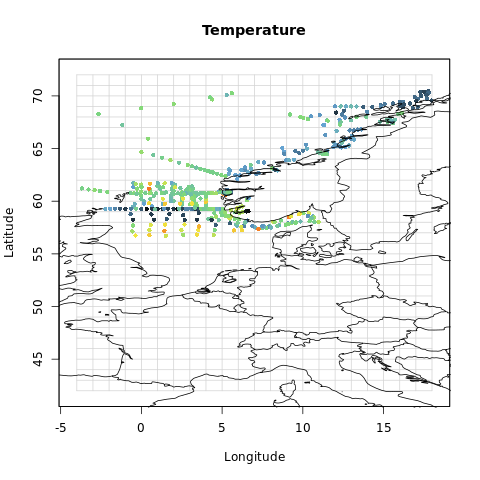

In [39]:
%%R
colors.temp = rg.colors(rank=1)
var_scale0 = get_db_limits_var(db0,var)
display_var(db0, var = var, colors = colors.temp, title = var, filename = var)

#### Display with other Projections


Parameters for Projection
-------------------------
Projection is switched ON
Use 'projec.define' to modify previous values


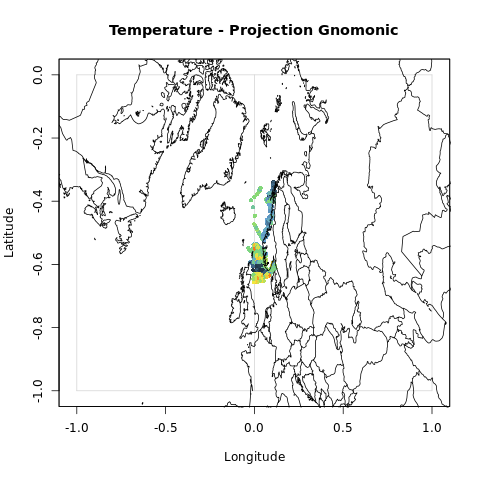

In [40]:
%%R
filename = paste0(var," - Projection Gnomonic")
projec.define(projection="gnomonic")
display_var(db0, var = var, colors = colors.temp, title = filename, filename = filename)
projec.toggle(0)


Parameters for Projection
-------------------------
Projection is switched ON
Use 'projec.define' to modify previous values


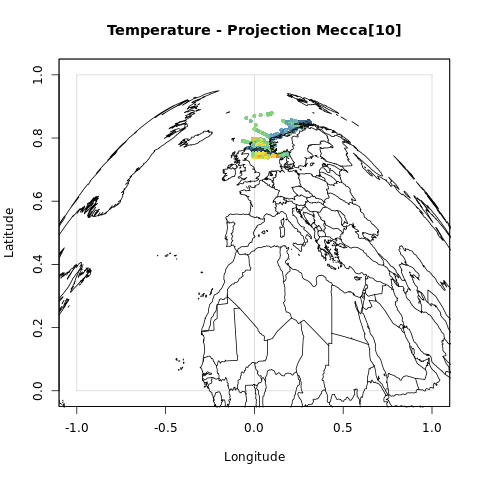

In [41]:
%%R
filename = paste0(var," - Projection Mecca[10]")
projec.define(projection="mecca",parameters=10)
display_var(db0, var = var, colors = colors.temp, title = filename, filename = filename)
projec.toggle(0)

### Year Campaign

We display Temperature values for one year only.

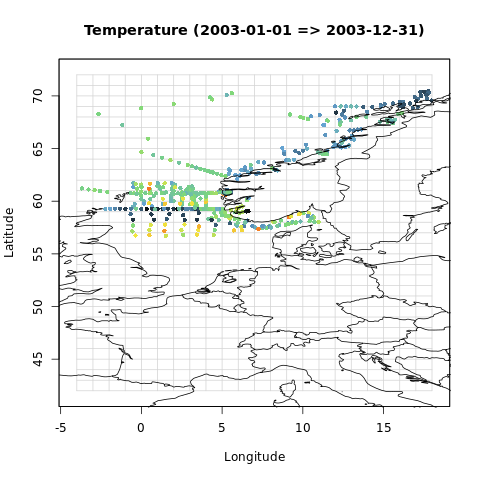

In [42]:
%%R

# Comment the following line if you want to to display all years
subyears = years[1]

# Loop on the years to be displayed
for (year in subyears) 
{
  date_lim  = create_limits_date(year)
  db        = apply_sel(db0, date_lim=date_lim)
  filename  = paste0(var,"_Year_",year)
  title     = build_title(var, date_lim)
  display_var(db, var, var_scale = var_scale0, colors = colors.temp, 
              title = title, filename = filename)
}

### Year/Trimester at specific Depth

Display data for the first trimester of the year 1995 focusing on data one depth exactly.

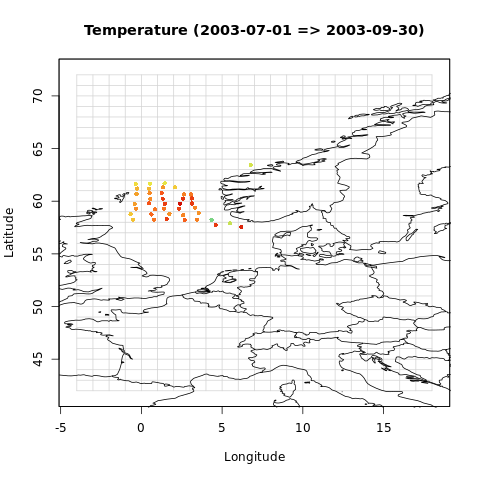

In [44]:
%%R

# Select samples at specific depth and set the color scale
depth = 20 # must be within the available range
depth_lim=c(depth,depth)

db1       = apply_sel(db0, depth_lim=depth_lim, compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following lines if you want to to display all trimesters / years
subyears = years[1]
subtrims = trimesters[3]

# Loop on the years / trimesters to be displayed
for (year in subyears) 
  for (itri in subtrims)
  {
    date_lim  = create_limits_date(year, trimester=itri)
    db        = apply_sel(db1,date_lim=date_lim)
    filename  = paste0(var,"_Trim_",year,"_T",itri)
    title     = build_title(var, date_lim)
    display_var(db, var,  var_scale = var_scale, colors = colors.temp,
                title = title, filename = filename)
  }

### Block Average at given Depth

The next display considers the variable averaged over the cells of a coarse grid (mesh of 1 degree).

In [53]:
%%R
depth2

[1] 50


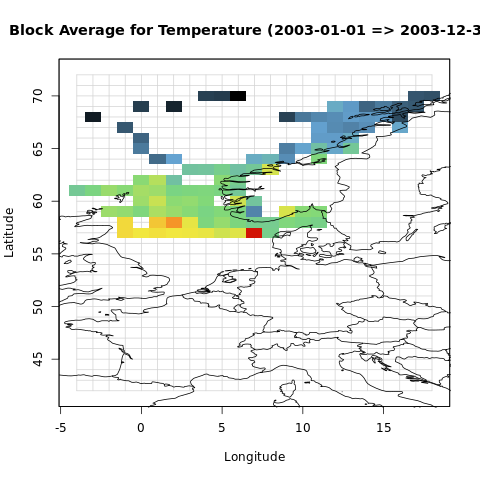

In [54]:
%%R
depth_lim=c(depth1,depth2)

# Select samples and set the color scale
db1       = apply_sel(db0, depth_lim=depth_lim,compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following line if you want to to display all years
subyears = years[1]

# Loop on the years
for (year in subyears) 
{
  date_lim  = create_limits_date(year)
  db        = apply_sel(db1, date_lim=date_lim)
  filename  = paste0(var,"_Mean_",year)
  title     = paste("Block Average for", build_title(var, date_lim))
  dbg       = stats_grid(db, var, fun = "mean", mesh = 1)
  display_stats(dbg, var, var_scale = var_scale, colors = colors.temp,
                title = title, filename = filename)
}

### Histogram of Measurement Depths

We also aggregate the values of all samples vertically from 0m to 100m by 10 steps of 10m.
Then, we can double-check this regularization step by plotting the histogram of the initial depths and the histogram of the depths in the aggregated file.

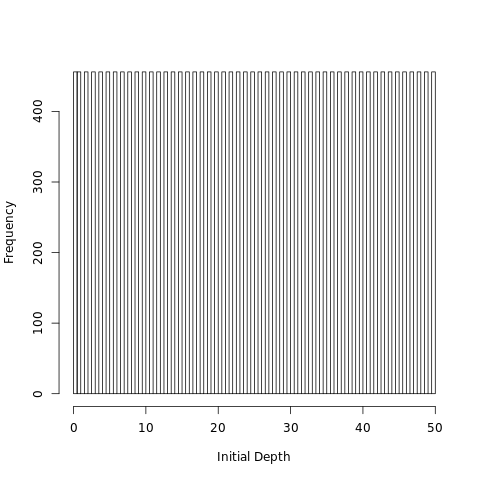

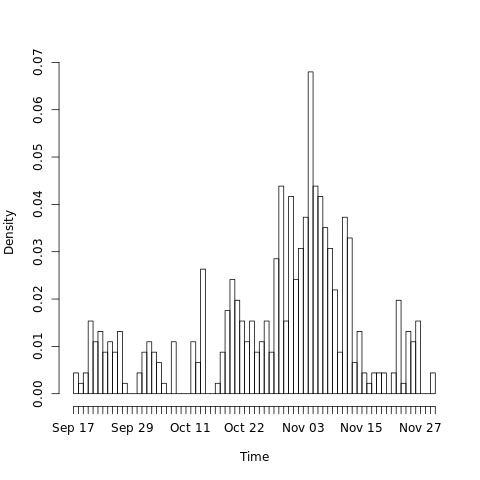

In [55]:
%%R
# Aggregate data along Depth axis
# dbin:       input data grid
# depth0:     origin of depth values
# ddepth:     step along depth
# ndepth:     number of depth steps

dbreg = aggregate_depth(db0, depth0 = depth1, ddepth = 1, ndepth = 10, flag.center = TRUE)

# Histogram of depths
hist(db0[,"Depth"],breaks=100,xlab="Initial Depth",main="")
hist(time2date(db0[,"Time"]),breaks=100,xlab="Time",main="")

## Statistics per Depth
Consider one year, and evaluate the mean and variance of the Temperature per depth level (every 1m). Calculations are performed starting from the initial data set.

In [56]:
%%R
average_depth_withNA <- function(dbin, var, depth0, ndepth, ddepth)
{
  depths = numeric(ndepth)
  count  = numeric(ndepth)
  means  = numeric(ndepth)
  vars   = numeric(ndepth)

  for (i in 1:ndepth)
  {
    dbin = remove_sel(dbin)
    depths[i] = ddepth * (i + 0.5)
    depth_lim = c(depths[i] - ddepth/2, depths[i] + ddepth/2)
    dbin = apply_sel(dbin, depth_lim = depth_lim)
   
    # Calculate the mean and variance
    tab      = db.extract(dbin,var)
    count[i] = length(tab)
    means[i] = mean(na.omit(tab))
    vars[i]  = var(na.omit(tab))
  }
  res = list(count=count, means=means, vars=vars, depths=depths)
  res
}

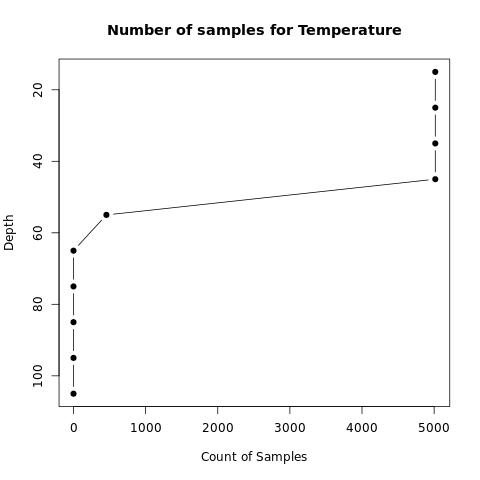

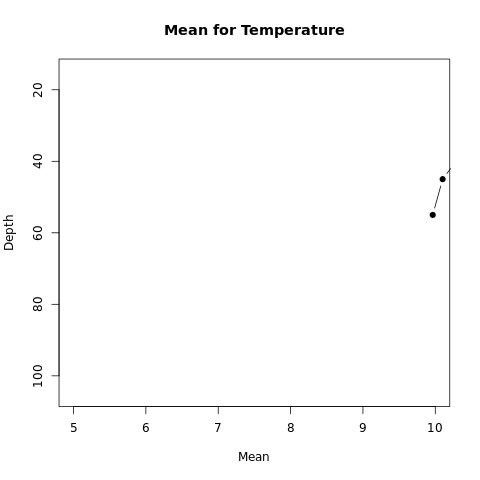

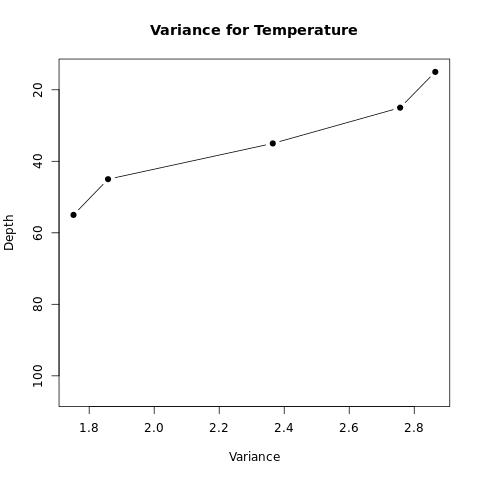

In [57]:
%%R
# Average Temperature by depth
date_lim  = create_limits_date(year)
db1       = apply_sel(db0, date_lim = date_lim, compress = TRUE)
res       = average_depth_withNA(db1, var, depth0 = depth1, ndepth = 10, ddepth = 10)

# Display statistics
plot(res$count,res$depths,type="b",main=paste("Number of samples for",var),pch=19,
     xlab="Count of Samples", ylab="Depth", ylim=rev(range(res$depths)))
plot(res$means,res$depths,type="b",main=paste("Mean for",var),pch=19,
     xlab="Mean", ylab="Depth", ylim=rev(range(res$depths)), xlim=range(5,10))
plot(res$vars ,res$depths,type="b",main=paste("Variance for",var),pch=19,
     xlab="Variance", ylab="Depth", ylim=rev(range(res$depths)))

## Regularization along Time

Starting from the initial data base, regularize the Temperature every 30 days by calcuting its mean for each interval

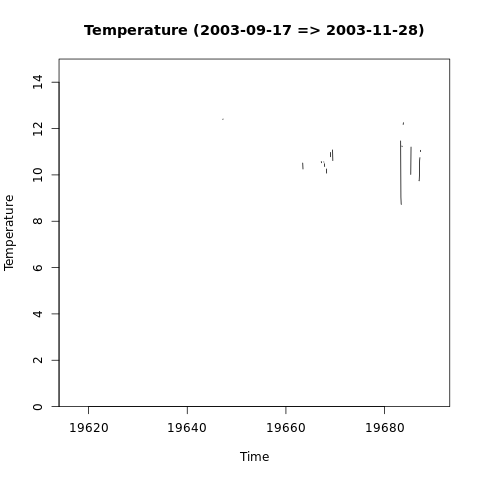

In [58]:
%%R
# Regularize Temperature along Time
dbg = regular_time(db0, var, time_step = 0.05)

# Display regularized 1-D database along time
plot(dbg, title = build_title_db_time(dbg,var), xlab = "Time", ylab = var, ylim=c(0,15))

## Regularization along Depth

Starting from the initial data, regularize the Temperature every #m depth

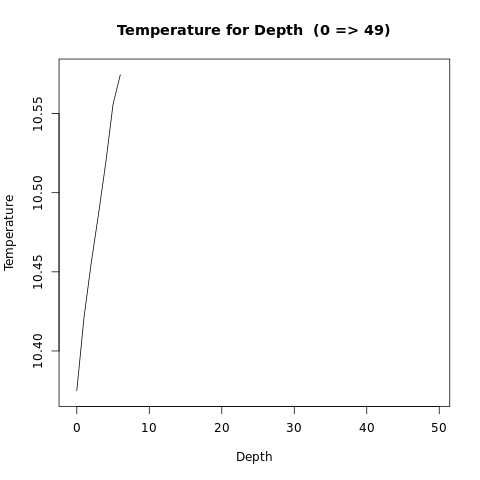

In [59]:
%%R 
# Regularize Temperature along Depth
dbg = regular_depth(db0, var, depth_step = 1)

# Display regularized 1-D database along depth
plot(dbg, title=build_title_db_depth(dbg,var), xlab="Depth", ylab = var)

## Horizontal Variogram per Year

Review the horizontal variograms for different years at a given depth, calculated from the aggregated data set.

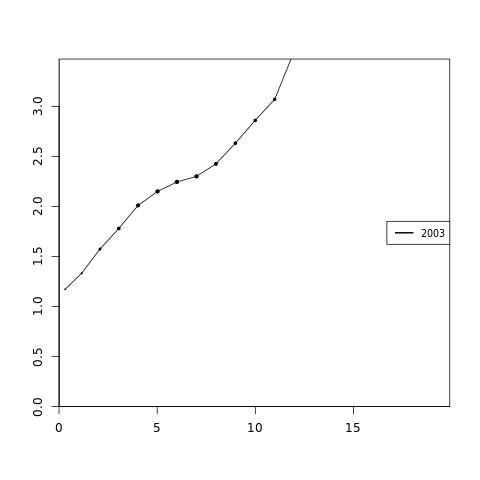

In [60]:
%%R
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)
rres      = average_time(dbr, var, years)
# Store the maximum variance for further use
varmax = 1.2 * max(rres$vars)
# varmax = 3

# Define the active samples
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)
dbr       = db.locate(dbr,var,"z")

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Loop on the years
ecr = 1
add = FALSE
for (year in years) 
{
  date_lim = create_limits_date(year)
  dbr = remove_sel(dbr)
  dbr = apply_sel(dbr, date_lim = date_lim)

  vario = prepar_vario(dbr, dirvect=NA, 
                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,
                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,
                       varline=FALSE, npairdw=TRUE)

  ecr = ecr + 1
  add = TRUE
}
legend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)

## Cross-Validation

We first perform a cross-validation step


Cross-Validation Scores
-----------------------
                             Number      Mean  Variance
Xvalid.Temperature.esterr        43     0.022     0.429
Xvalid.Temperature.stderr        43     0.012     1.734



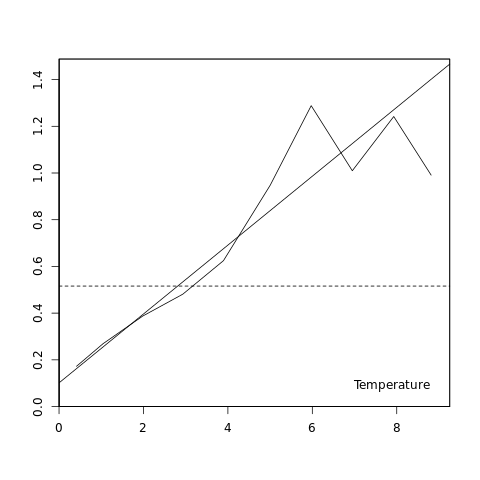

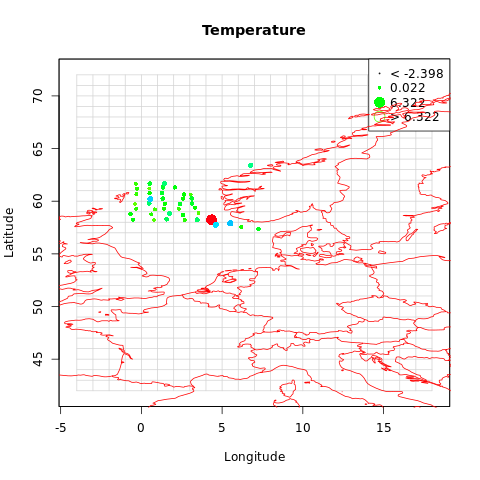

In [63]:
%%R 
# Define the active samples
date_lim  = create_limits_date(year, trimester=3) # NB change trimester number based on available dates
dbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Perform the Cross-validation (includes Variogram calculation and Model fitting)
dbp = xvalid_2D(dbr, var,  
                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                dirvect = NA, draw.model=TRUE, radix="Xvalid")
db.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")

# Display the results
filename  = paste0("Xvalid_",var)
display_var(dbp, var = "*stderr", flag.xvalid = TRUE, colors = rainbow(100),
            title = var, filename = filename, pos.legend=7)

## 2-D Estimation of Temperature

We interpolate the Temperature for the second trimester of year 2008, at the depth of 25m. This interpolation starts from the aggregated data.

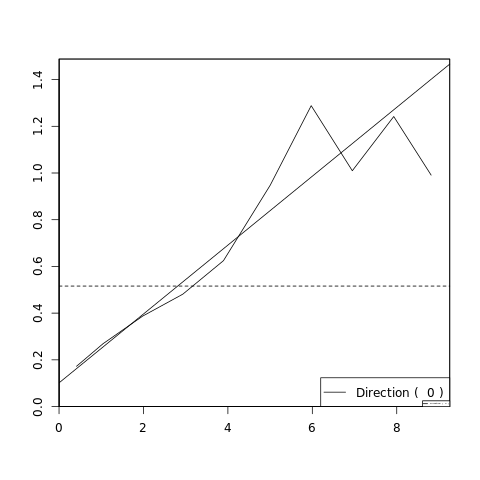

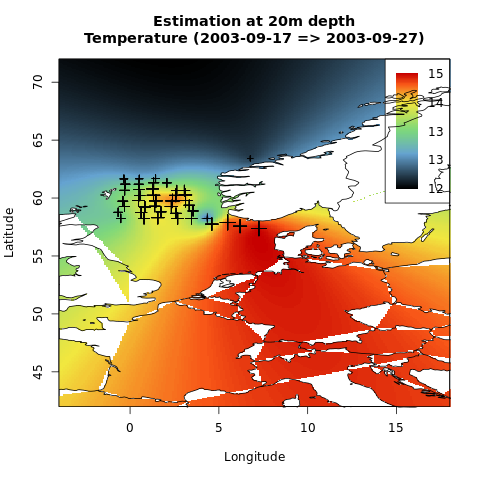

In [66]:
%%R 
# Select the active samples
depth = depth

depth_lim = c(depth1,depth2)
date_lim  = create_limits_date(year, trimester=3)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(dbr, var, mesh = 0.1, moving=FALSE, 
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_Year_",year)
display_result(dbr, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)